In [18]:
import os

# define cache for sentencebert
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/plarosa/ .cache'

import time
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import nlpaug
import nlpaug.augmenter.word as naw

from automl_prec import AutoML


### Extract Data

In [19]:
def get_abstract_data(db_path='../data/db.sqlite3'):
    """ outputs a dataframe with abstract and school_id
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
                        
    Returns
    ===========
    get_abstract_data    :   pandas.DataFrame
                             unique abstract and school_id
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.abstract,
           rp.school_id
    FROM research_profile rp
    WHERE rp.abstract IS NOT NULL
    AND rp.school_id IS NOT NULL
    GROUP BY rp.abstract, rp.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    return df

df = get_abstract_data()

In [20]:


import pickle
with open('plots/fig_data/df_res_spec.pickle', 'wb') as f:
    pickle.dump(df, f)


### EDA

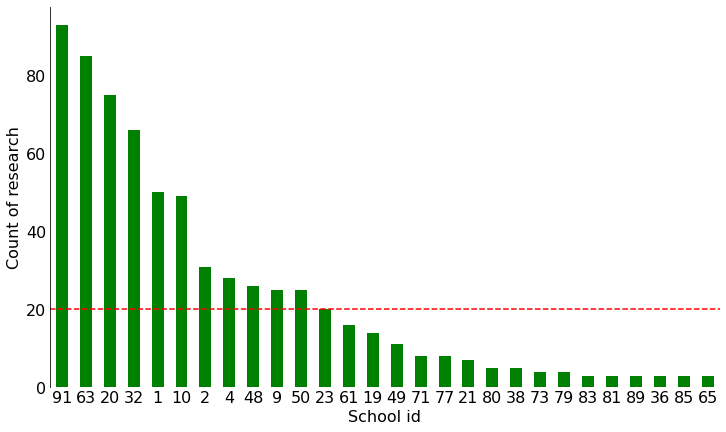

In [27]:
df.school_id.value_counts()[:28].plot.bar(figsize=(12, 7), color='green')
plt.axhline(20, color='red',linestyle='--')
plt.tick_params(axis='both', which='both', length=0)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.bottom.set_visible(False)
plt.xlabel('School id')
plt.xticks(rotation = 0)
plt.ylabel('Count of research')
axes = plt.gca()
axes.set_xlabel('School id', fontsize=16)
axes.set_ylabel('Count of research', fontsize=16)
axes.tick_params(axis='x', labelsize=16)
axes.tick_params(axis='y', labelsize=16);

Note:
- Highly imbalanced dataset
- Choose only schools with at least 20 research papers produced

In [28]:
school_count = df.school_id.value_counts()
top_schools = school_count[school_count > 20].index.tolist()

data = df[df.school_id.isin(top_schools)]

### Preprocess

In [29]:
# remove tagalog abstract - out of scope
data = data.drop([112, 167, 638, 648, 663])

In [30]:
# casefold abstract - because pretrained is uncased
# remove punctuations - does not add any meaning
data['abstract'] = (data.abstract.str.lower()
                        .str.replace('“', '', regex=False)
                        .str.replace(':', '', regex=False)
                        .str.replace('(', '', regex=False)
                        .str.replace(')', '', regex=False))

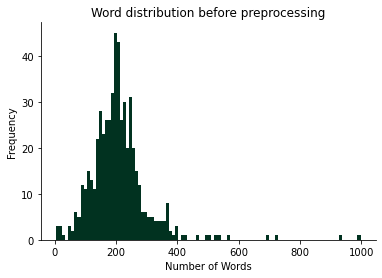

In [31]:
data.abstract.str.split(' ').apply(lambda x: len(x)).hist(bins=100, 
                                                          grid=False, 
                                                         color='#013220' )
plt.title('Word distribution before preprocessing')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

In [32]:
# remove outlier length
length = data.abstract.str.split(' ').apply(lambda x: np.log(len(x)))
data = data[((length - length.mean())/length.std()) > -3]

<AxesSubplot:>

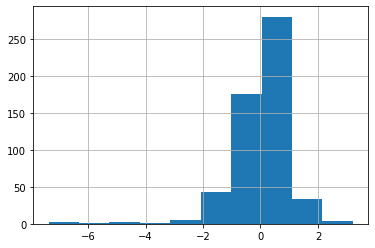

In [33]:
((length - length.mean())/length.std()).hist()

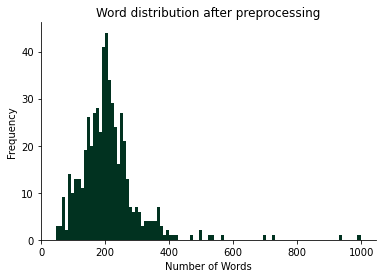

In [34]:
# check histogram after preprocessing
data.abstract.str.split(' ').apply(lambda x: len(x)).hist(bins=100,
                                                         grid=False, 
                                                         color='#013220')
plt.title('Word distribution after preprocessing')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

In [35]:
# load sentence transformer model
# model = SentenceTransformer('allenai/scibert_scivocab_uncased')
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

In [36]:
# encode abstract using pretrained model
start_time = time.time()
embeddings = model.encode(data.abstract.tolist(), convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

Time for computing embeddings: 7.279507637023926


### Model Training 

#### Baseline Models

In [37]:
X = pd.DataFrame(embeddings.cpu().numpy())
y = data.reset_index(drop=True)['school_id']

le = LabelEncoder()
y = le.fit_transform(y)


In [60]:
counts = pd.Series(y).value_counts()
pcc = (counts / counts.sum()) ** 2
pcc = pcc.sum() * 1.25
print("Proportional Chance Criterion (PCC): ", pcc)

Proportional Chance Criterion (PCC):  0.1397126906085465


knn Classification: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


,Machine Learning Method,Test Precision,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.245144,max_depth = 8,632,17.559858
1,Random Forest,0.346846,max_depth = 8,320,31.516039
2,Logistic Regression (l1),0.464110,C = 1000,701,88.294666
3,Linear SVM (l1),0.456678,C = 100,701,678.029731
4,Logistic Regression (l2),0.448573,C = 100,454,310.589856
5,Linear SVM (l2),0.464589,C = 0.1,644,258.474905
739,knn Classification,0.458047,n_neighbors = 1,NA,7.630245


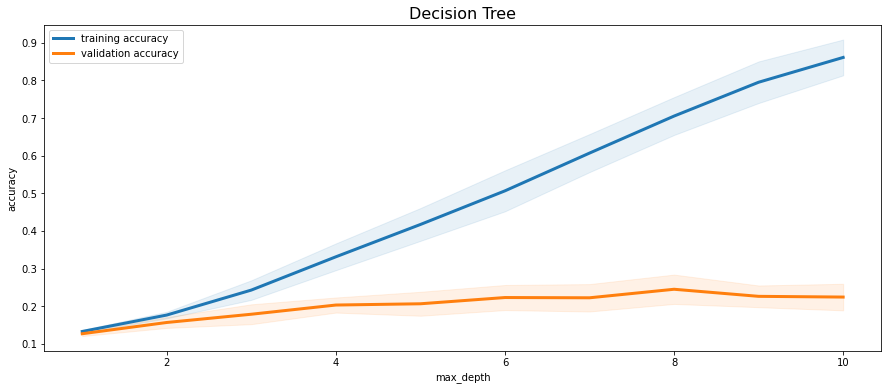

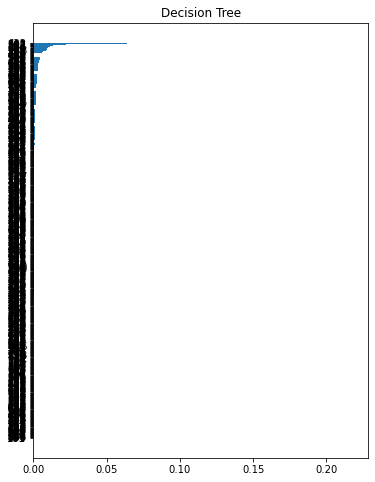

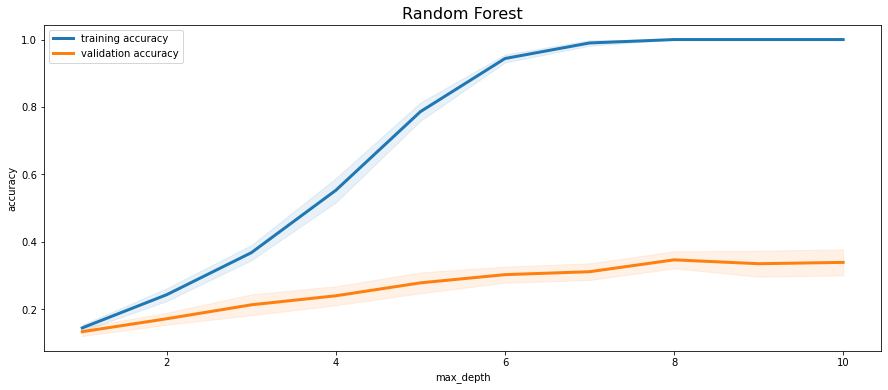

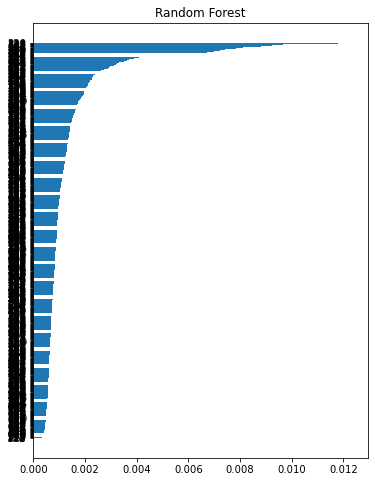

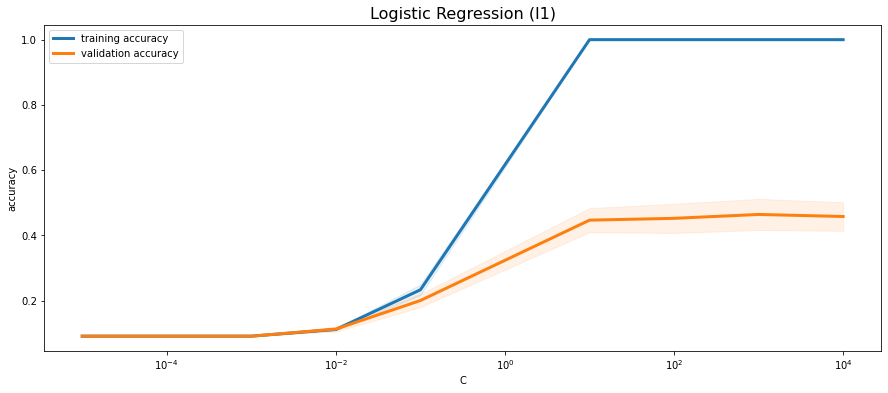

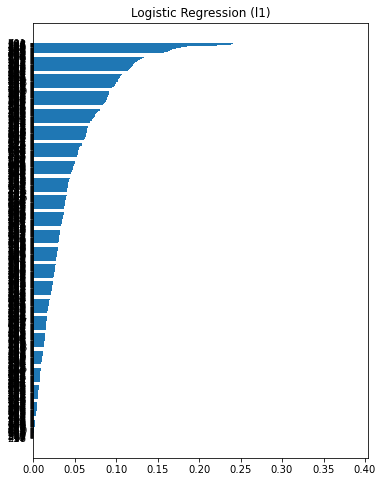

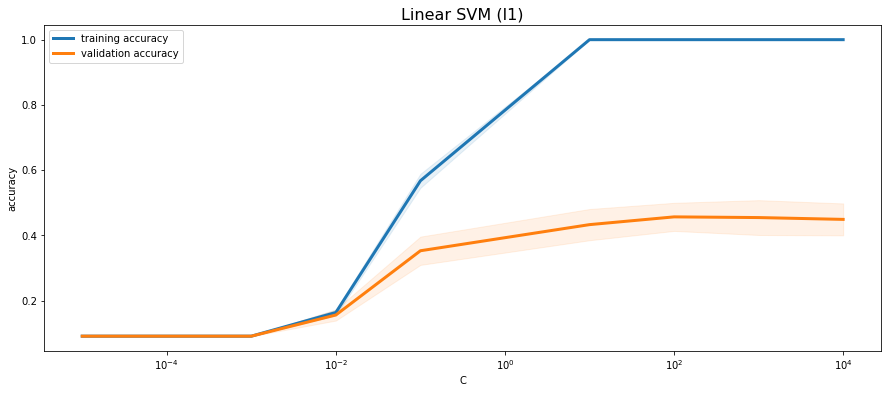

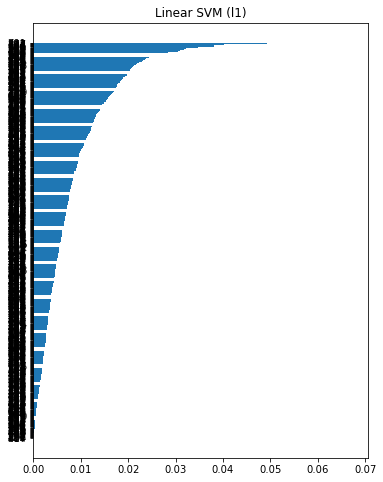

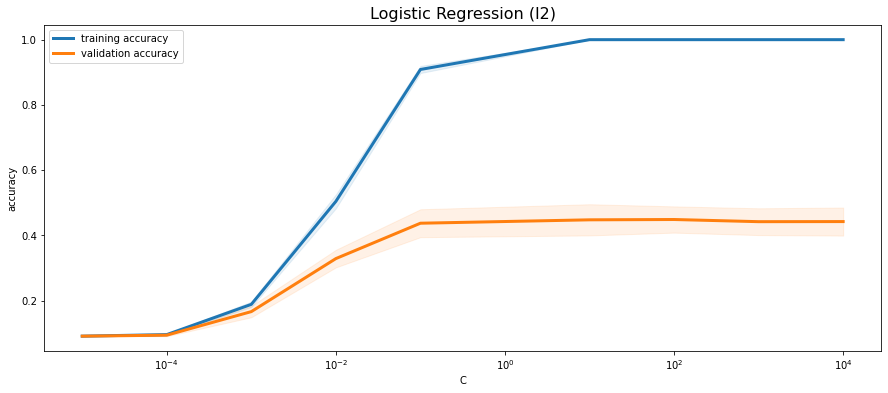

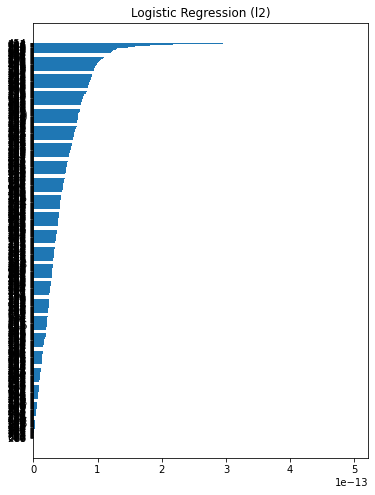

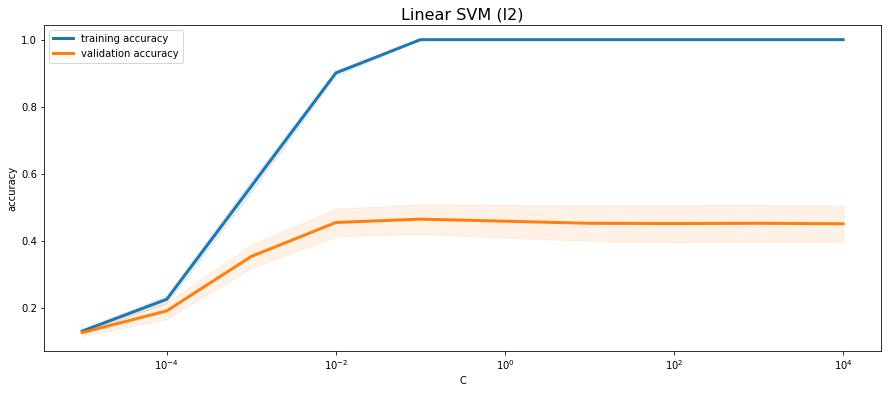

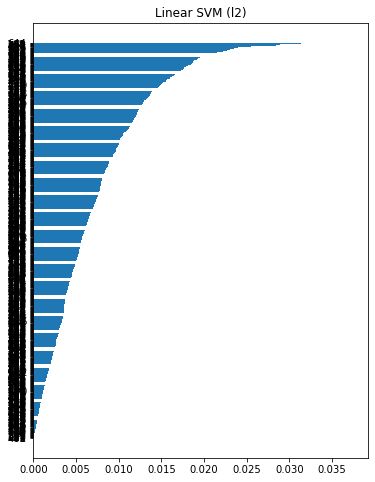

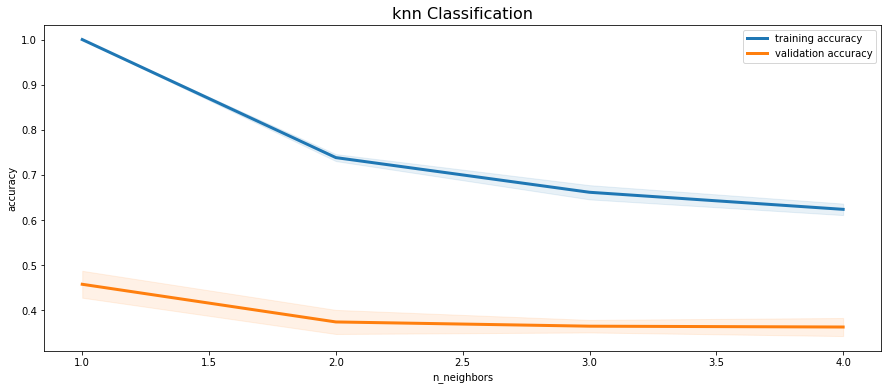

In [61]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df1.columns)
df1.loc[len(df)] = knc_summary
display(df1)

Notes:
- Models took time to train
- Mostly overfitting

#### With Dimensionality Reduction

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings.cpu())

In [ ]:
X = pd.DataFrame(umap_embeddings)

In [ ]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df2 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df.columns)
df.loc[len(df2)] = knc_summary
display(df2)

Notes:
- Speed improve
- Accuracy decrease

### Using Abstract Summary

In [ ]:
df_summary = pd. read_pickle('../data/abs_summary.pkl')

In [ ]:
merge_summ = pd.merge(df, 
                     df_summary.drop_duplicates(subset='abstract'), 
                     on='abstract')

In [ ]:
school_count = merge_summ.school_id.value_counts()
top_schools = school_count[school_count > 20].index.tolist()

data = merge_summ[merge_summ.school_id.isin(top_schools)]

In [ ]:
# encode abstract using pretrained model
start_time = time.time()
embeddings = model.encode(data.summary.tolist(), convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

In [29]:
X = pd.DataFrame(embeddings.cpu().numpy())
y = data.reset_index(drop=True)['school_id']

le = LabelEncoder()
y = le.fit_transform(y)


In [ ]:
def get_abstract_data(db_path='../data/db.sqlite3'):
    """ outputs a dataframe with abstract and school_id
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
                        
    Returns
    ===========
    get_abstract_data    :   pandas.DataFrame
                             unique abstract and school_id
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.abstract,
           rp.school_id
    FROM research_profile rp
    WHERE rp.abstract IS NOT NULL
    AND rp.school_id IS NOT NULL
    GROUP BY rp.abstract, rp.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    return df

df = get_abstract_data()

In [ ]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df3 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df3.columns)
df3.loc[len(df3)] = knc_summary
display(df3)

Notes:
- Speed improve
- Accuracy decrease

### Evaluation

In [38]:
from sklearn.metrics import precision_score

(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = LinearSVC(C=0.1)
model.fit(X_train, y_train);

In [39]:
print(precision_score(model.predict(X_test), y_test, average='macro'))
print(model.score(X_test, y_test))


0.48409428380655994
0.5441176470588235


In [25]:
with open('research_spec.pickle', 'wb') as f:
    pickle.dump(model, f)

<AxesSubplot:>

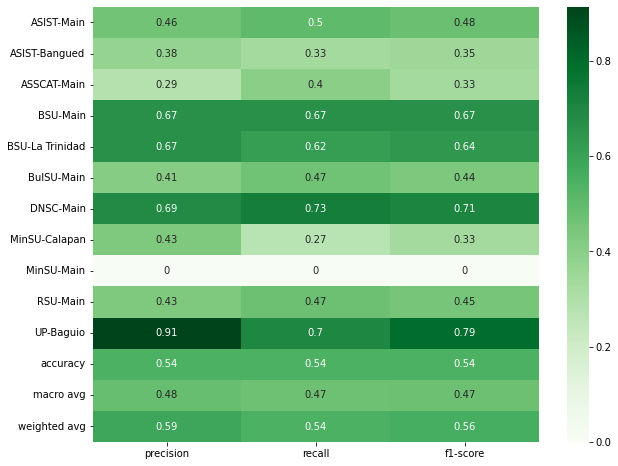

In [40]:
school_mapping = {
    0 : 'ASIST-Main',
    1 : 'ASIST-Bangued',
    2 : 'ASSCAT-Main',
    3 : 'BSU-Main',
    4 : 'BSU-La Trinidad',
    5 : 'BulSU-Main', 
    6 : 'DNSC-Main', 
    7 : 'MinSU-Calapan',
    8 : 'MinSU-Main', 
    9 : 'RSU-Main', 
    10 : 'UP-Baguio'
}

plt.figure(figsize=(10, 8))
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)

clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :].T
clf_report_df.index = [school_mapping[int(col)] 
                       if col not in ['accuracy', 'macro avg', 'weighted avg'] 
                       else col for col in clf_report_df.index]

sns.heatmap(clf_report_df, annot=True, cmap='Greens')


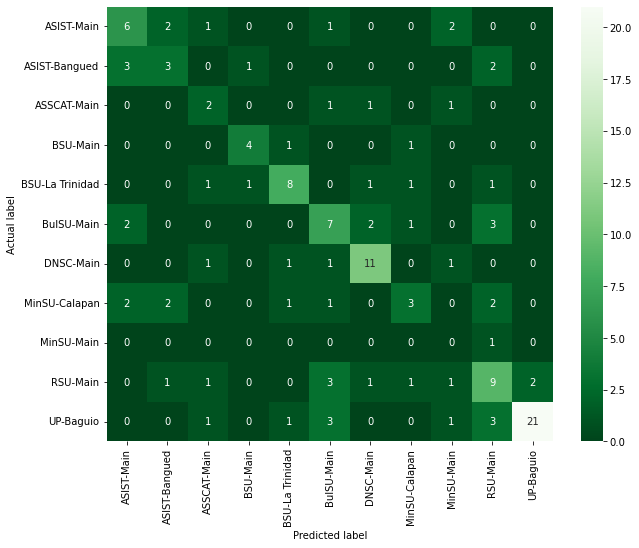

In [43]:
plt.figure(figsize=(10, 8))
cf_matrix = confusion_matrix(model.predict(X_test), y_test,
                            )

cf_df = pd.DataFrame(cf_matrix)
cf_df.columns = [school_mapping[col] for col in cf_df.columns]
cf_df.index = [school_mapping[col] for col in cf_df.index]


sns.heatmap(cf_df, annot=True, cmap='Greens_r')
# plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual label');

### Text Augmentation

In [ ]:
import nlpaug
import nlpaug.augmenter.word as naw

In [ ]:
train, test = train_test_split(data,
                               test_size=0.25,
                               random_state=143, 
                               shuffle=True,
                               stratify=data.school_id)


In [ ]:
le = LabelEncoder()
y = le.fit_transform(train.school_id)
train['target'] = y
school_dist = pd.Series(y).value_counts()
sample_needed = (school_dist.max() * 0.7) - school_dist
sample_needed = sample_needed.apply(lambda x: x if x > 0 else 0)

In [ ]:
# model_type: glove
aug_w2v = naw.WordEmbsAug(
    model_type='glove', model_path='./models/glove.6B.100d.txt',
    action="substitute")

In [ ]:
def augment_text(df,samples=sample_needed,pr=0.2):
    aug_w2v.aug_p=pr
    
    for target in sample_needed.index:
        ##selecting the minority class samples
        df_n=df[df.target==target].reset_index(drop=True)
        new_abstract=[]
        if sample_needed[target]:
            ## data augmentation loop
            for i in tqdm(np.random.randint(0, len(df_n), 
                                            int(sample_needed[target]))):

                    text = df_n.iloc[i]['abstract']
                    augmented_text = aug_w2v.augment(text)
                    new_abstract.append(augmented_text)


            ## dataframe
            new=pd.DataFrame({'abstract':new_abstract, 'target':target})
            df=shuffle(df.append(new).reset_index(drop=True))
        
    return df
   
train_aug = augment_text(train)

In [ ]:
train_aug.target.value_counts().plot.bar()

In [ ]:
train.target.value_counts().plot.bar()

In [ ]:
test['target'] = le.transform(test.school_id)

In [ ]:
# load sentence transformer model
emb_model = SentenceTransformer('allenai/scibert_scivocab_uncased')
emb_model.max_seq_length = 512

# encode abstract using pretrained model
start_time = time.time()
embeddings_train = emb_model.encode(train_aug.abstract.tolist(), 
                              convert_to_tensor=True)

embeddings_test = emb_model.encode(test.abstract.tolist(), 
                              convert_to_tensor=True)

end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

In [ ]:
X_train = pd.DataFrame(embeddings_train.cpu().numpy())
y_train = train_aug.reset_index(drop=True)['target']

X_test = pd.DataFrame(embeddings_test.cpu().numpy())
y_test = test.reset_index(drop=True)['target']

model = LinearSVC(C=0.1)
model.fit(X_train, y_train);

In [ ]:
plt.figure(figsize=(10, 8))
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report');

### Varying number of schools

In [34]:
from tqdm import tqdm

precisions = []
accuracies = []
for i in tqdm(range(0, 76, 5)):
    try:
        school_count = df.school_id.value_counts()
        top_schools = school_count[:i+5].index.tolist()

        data = df[df.school_id.isin(top_schools)]

        # remove tagalog abstract - out of scope
        data = data.drop([112, 167, 638, 648, 663], errors='ignore')

        # casefold abstract - because pretrained is uncased
        # remove punctuations - does not add any meaning
        data['abstract'] = (data.abstract.str.lower()
                                .str.replace('“', '', regex=False)
                                .str.replace(':', '', regex=False)
                                .str.replace('(', '', regex=False)
                                .str.replace(')', '', regex=False))

        # remove outlier length
        length = data.abstract.str.split(' ').apply(lambda x: np.log(len(x)))
        data = data[abs((length - length.mean())/length.std()) < 3]

        start_time = time.time()
        embeddings = model.encode(data.abstract.tolist(), convert_to_tensor=True)
        end_time = time.time()

        X = pd.DataFrame(embeddings.cpu().numpy())
        y = data.reset_index(drop=True)['school_id']

        le = LabelEncoder()
        y = le.fit_transform(y)


        (X_train, X_test, 
         y_train, y_test) = train_test_split(X, y,
                                            test_size=0.25,
                                            random_state=143, 
                                            shuffle=True,
                                            stratify=y)

        model_svc = LinearSVC(C=0.1)
        model_svc.fit(X_train, y_train);

        precisions.append(precision_score(model_svc.predict(X_test), y_test, average='macro'))
        accuracies.append(model_svc.score(X_test, y_test))
    except:
        break

 31%|███▏      | 5/16 [00:29<01:10,  6.37s/it]/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 38%|███▊      | 6/16 [00:42<01:10,  7.04s/it]


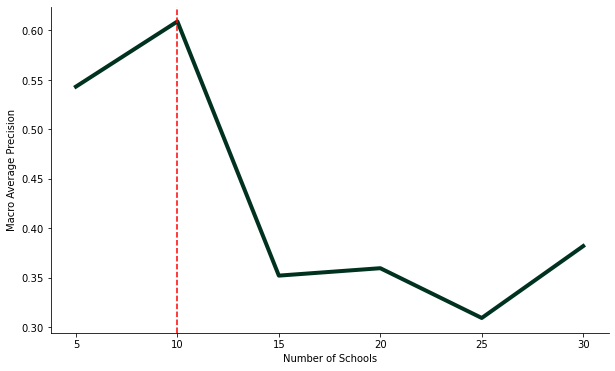

In [86]:

plt.figure(figsize=(10, 6))
x = [5, 10, 15, 20, 25, 30]
plt.plot(x, precisions, lw=4, color='#013220')
plt.axvline(10, color='red',linestyle='--')
plt.xlabel('Number of Schools')
plt.ylabel('Macro Average Precision')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

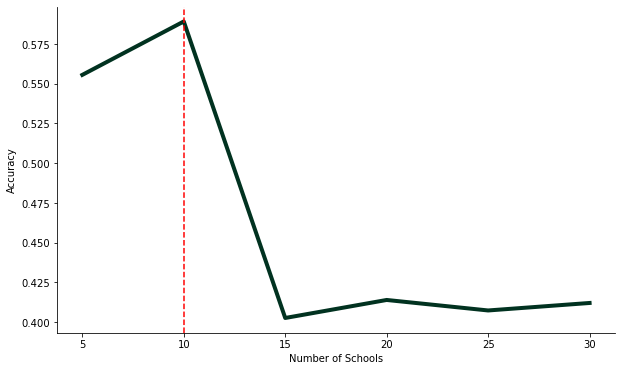

In [85]:

plt.figure(figsize=(10, 6))
x = [5, 10, 15, 20, 25, 30]
plt.plot(x, accuracies, lw=4, color='#013220')
plt.axvline(10, color='red',linestyle='--')
plt.xlabel('Number of Schools')
plt.ylabel('Accuracy')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)